Please do one of the following.


# Part I: Classification

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [1]:
import numpy as np
import os
from sklearn.linear_model import Ridge
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import openpyxl
import pandas as pd
import time 
import csv
import operator
import datetime
from datetime import date
from pulp import *
import itertools
import seaborn 
from collections import defaultdict
from sklearn import preprocessing
from flask import Flask
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
import random
import json
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from pandas.tools.plotting import scatter_matrix 
import re
import pylab as plt
import seaborn
import seaborn as sns
from sklearn import preprocessing
pd.set_option('display.max_columns', 500)
%matplotlib inline

Default = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)
Default.head()

/Users/Mailman82/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/Mailman82/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [2]:
df_default = pd.get_dummies(Default['default'])
df_student = pd.get_dummies(Default['student'])
df_result = pd.concat([df_default['Yes'], df_student['Yes'], Default[['balance', 'income']]], axis=1)
colnames = ['default', 'student', 'balance', 'income']
df_result.columns = colnames
df_result.head()

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

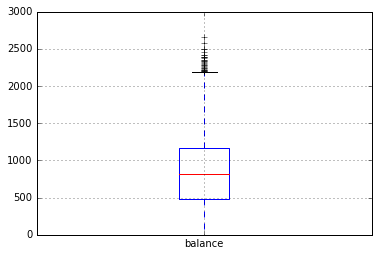

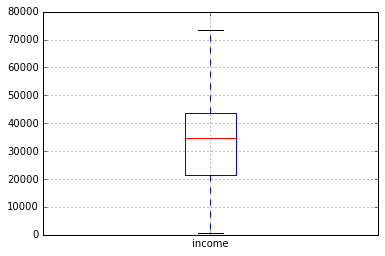

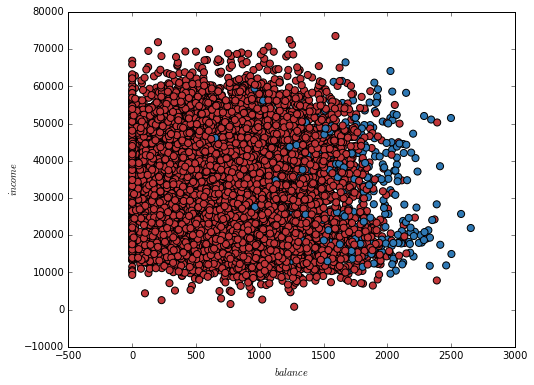

In [4]:
df_result.boxplot('balance')
plt.show()
df_result.boxplot('income')
plt.show()
df_default = df_result.drop(['student'],1)
f, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df_result['balance'], df_result['income'], c=df_result['default'], s=50, cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="black")
ax.set(xlabel="$balance$", ylabel="$income$")
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

<type 'numpy.ndarray'>
Area under the ROC curve : 0.960949


/Users/Mailman82/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/Mailman82/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


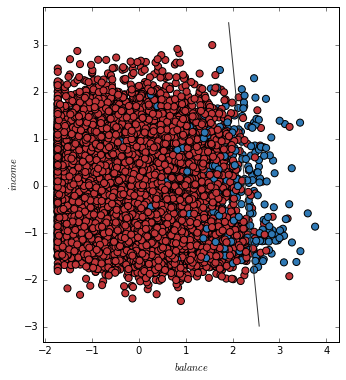

[]

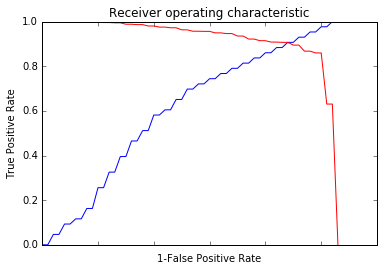

In [5]:
X = df_result.drop(['default','student'],1)
y = df_result['default']
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
   
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

scaler = StandardScaler()
X = X.as_matrix()
print(type(X))
X = scaler.fit_transform(X)
X = np.where(np.isnan(X), 0, X)
y = np.where(np.isnan(y), 0, y)
coeff = run_cv(X,y,LogisticRegression,C=.1,penalty='l1')

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')


clf = LogisticRegression().fit(X, y)
xx, yy = np.mgrid[0:4:.01, -3:3.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
f, ax = plt.subplots(figsize=(8, 6))
ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

ax.scatter(X[:,0], X[:,1], c=y, s=50, cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="black", linewidth=1)

ax.set(aspect="equal", xlabel="$balance$", ylabel="$income$")

plt.show()

i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.loc[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

Area under the ROC curve : 0.962152


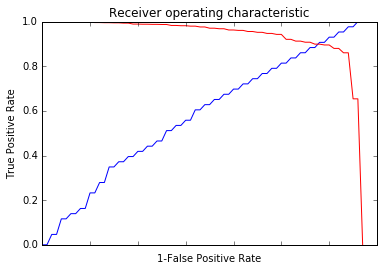

Area under the ROC curve : 0.948176
Area under the ROC curve : 0.948419
Area under the ROC curve : 0.948605
Area under the ROC curve : 0.949121
Area under the ROC curve : 0.949808
Area under the ROC curve : 0.950753
Area under the ROC curve : 0.951598
Area under the ROC curve : 0.952844
Area under the ROC curve : 0.954018
Area under the ROC curve : 0.955064
Area under the ROC curve : 0.956238
Area under the ROC curve : 0.957212
Area under the ROC curve : 0.958099
Area under the ROC curve : 0.958987
Area under the ROC curve : 0.959517
Area under the ROC curve : 0.960018
Area under the ROC curve : 0.960562
Area under the ROC curve : 0.960706
Area under the ROC curve : 0.961006
Area under the ROC curve : 0.961307
Area under the ROC curve : 0.961450
Area under the ROC curve : 0.961665
Area under the ROC curve : 0.961708
Area under the ROC curve : 0.961737
Area under the ROC curve : 0.961765
Area under the ROC curve : 0.961851
Area under the ROC curve : 0.962066
Area under the ROC curve : 0

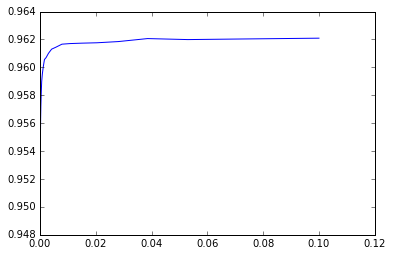

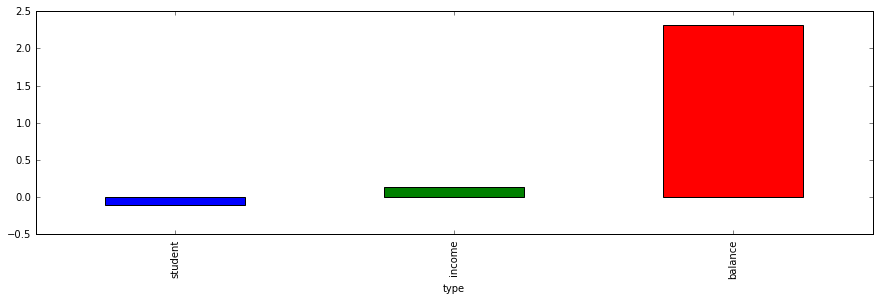

In [6]:
df_result['const']=1
X = df_result.drop(['default'],1)
dfX = df_result.drop(['default'],1)
y = df_result['default']
scaler = StandardScaler()
X = X.as_matrix()
X = scaler.fit_transform(X)
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')

i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.loc[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])
plt.show()

n_samples, n_features = X.shape

half = int(n_samples/2)
X_train, X_test = X[:half], X[half:]
y_train, y_test = y[:half], y[half:]

# Create linear regression object
N=30
alphas = np.logspace(-5,-1,N)

scores = []

for alpha in alphas:
    regr = LogisticRegression(C=alpha,penalty='l2')

    # Train the model using the training sets
    regr.fit(X_train, y_train)
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y,LogisticRegression,C=alpha,penalty='l2')
    scores.append(roc_auc)
plt.plot(alphas,scores)

alpha = alphas[np.argmax(scores)]

regr = LogisticRegression(C=alpha,penalty='l1')

# Train the model using the training sets
regr.fit(X_train, y_train)
dfCoeffs = pd.DataFrame({'type':dfX.columns.values, 'coef':regr.coef_[0]})
regr.coef_[0]

df_reduced = dfCoeffs[(dfCoeffs['coef']>0.1) | (dfCoeffs['coef']<-0.1)]

plt.figure(figsize=(15,4))
dfCoeffs2 = df_reduced.groupby('type')['coef'].mean()
dfCoeffs2.sort_values()
dfCoeffs2[::-1].plot(kind='bar')

Adding the student variable back into the dataframe improved the Area under the ROC curve.  The student variable provides another layer of data for the model to run through and although the student variable does show much ranking in the coefficients it does provide a difference in the overarching AUC ROC.

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

Coefficients with Four Folds


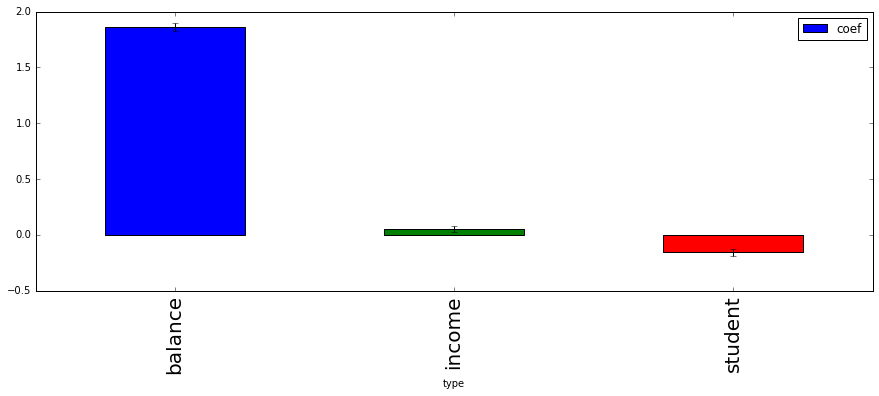

Coefficients with Six Folds


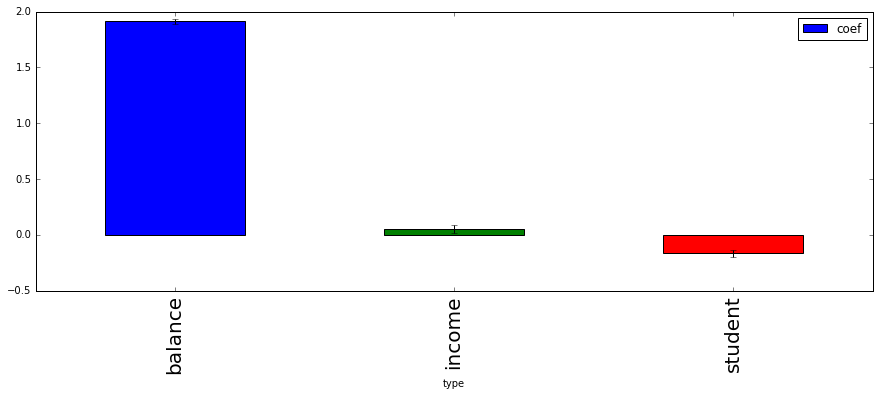

Coefficients with Ten Folds


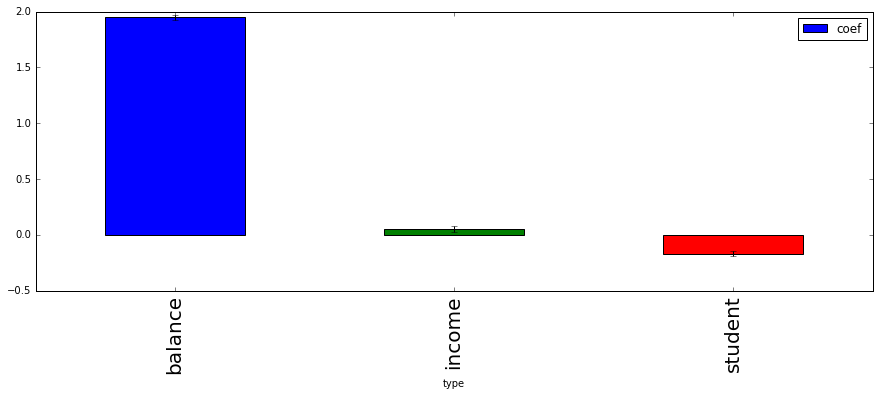

In [7]:
X = np.where(np.isnan(X), 0, X)
y = np.where(np.isnan(y), 0, y)
n_samples, n_features = X.shape

half = int(n_samples/2)
X_train, X_test = X[:half], X[half:]
y_train, y_test = y[:half], y[half:]

def run_cv_2(X,y,folds,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=folds,shuffle=True)
    y_pred = y.copy()
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
        coeffs.append(clf.coef_)
    return coeffs

#Four Folds
folds=4
print("Coefficients with Four Folds")
coeffs=run_cv_2(X,y,folds,LogisticRegression,C=.1,penalty='l2')
def get_coeffs(coeffs):
    coeffs_avgd = [(coeffs[0][0][i] + coeffs[1][0][i] + coeffs[2][0][i] + coeffs[3][0][i])/4 for i in range(0,len(dfX.columns))]
    coeffs_std = [np.std([coeffs[0][0][i],coeffs[1][0][i],coeffs[2][0][i],coeffs[3][0][i]]) for i in range(0,len(dfX.columns))]
    return coeffs_avgd, coeffs_std
coeffs_avg,coeffs_std=get_coeffs(coeffs)

dfCoeffs = pd.DataFrame({'type':dfX.columns.values, 'coef':coeffs_avg, 'std':coeffs_std})
dfCoeffs=dfCoeffs.drop(dfCoeffs.index[3])

plt.figure(figsize=(15,15))

dfCoeffs_sorted = dfCoeffs.sort_values(['coef'])[::-1]
yerr_vals = dfCoeffs_sorted['std'].values

threshold =0.01
dfCoeffs_sorted = dfCoeffs.sort_values(['coef'])[::-1]
dfCoeffs_sorted_r = dfCoeffs_sorted[(dfCoeffs_sorted['coef']< -threshold) | (dfCoeffs_sorted['coef']> threshold)]
yerr = dfCoeffs_sorted_r['std'].values
plt.rc('xtick', labelsize=20) 
dfCoeffs_sorted_r[0:10].plot(x='type',y='coef',yerr=yerr[0:10],kind='bar',figsize=(15,5))
plt.show()

#six Folds
folds=6
print("Coefficients with Six Folds")
coeffs=run_cv_2(X,y,folds,LogisticRegression,C=.1,penalty='l2')
def get_coeffs(coeffs):
    coeffs_avgd = [(coeffs[0][0][i] + coeffs[1][0][i] + coeffs[2][0][i] + coeffs[3][0][i] + coeffs[4][0][i] + coeffs[5][0][i])/6 for i in range(0,len(dfX.columns))]
    coeffs_std = [np.std([coeffs[0][0][i],coeffs[1][0][i],coeffs[2][0][i],coeffs[3][0][i],coeffs[4][0][i],coeffs[5][0][i]]) for i in range(0,len(dfX.columns))]
    return coeffs_avgd, coeffs_std
coeffs_avg,coeffs_std=get_coeffs(coeffs)

dfCoeffs = pd.DataFrame({'type':dfX.columns.values, 'coef':coeffs_avg, 'std':coeffs_std})
dfCoeffs=dfCoeffs.drop(dfCoeffs.index[3])

plt.figure(figsize=(15,15))

dfCoeffs_sorted = dfCoeffs.sort_values(['coef'])[::-1]
yerr_vals = dfCoeffs_sorted['std'].values

threshold =0.01
dfCoeffs_sorted = dfCoeffs.sort_values(['coef'])[::-1]
dfCoeffs_sorted_r = dfCoeffs_sorted[(dfCoeffs_sorted['coef']< -threshold) | (dfCoeffs_sorted['coef']> threshold)]
yerr = dfCoeffs_sorted_r['std'].values
plt.rc('xtick', labelsize=20) 
dfCoeffs_sorted_r[0:10].plot(x='type',y='coef',yerr=yerr[0:10],kind='bar',figsize=(15,5))
plt.show()

#Ten Folds
folds=10
print("Coefficients with Ten Folds")
coeffs=run_cv_2(X,y,folds,LogisticRegression,C=.1,penalty='l2')
def get_coeffs(coeffs):
    coeffs_avgd = [(coeffs[0][0][i] + coeffs[1][0][i] + coeffs[2][0][i] + coeffs[3][0][i] + coeffs[4][0][i] + coeffs[5][0][i] + coeffs[6][0][i] + coeffs[7][0][i] + coeffs[8][0][i] + coeffs[9][0][i])/10 for i in range(0,len(dfX.columns))]
    coeffs_std = [np.std([coeffs[0][0][i],coeffs[1][0][i],coeffs[2][0][i],coeffs[3][0][i],coeffs[4][0][i],coeffs[5][0][i],coeffs[6][0][i],coeffs[7][0][i],coeffs[8][0][i],coeffs[9][0][i]]) for i in range(0,len(dfX.columns))]
    return coeffs_avgd, coeffs_std
coeffs_avg,coeffs_std=get_coeffs(coeffs)

dfCoeffs = pd.DataFrame({'type':dfX.columns.values, 'coef':coeffs_avg, 'std':coeffs_std})
dfCoeffs=dfCoeffs.drop(dfCoeffs.index[3])

plt.figure(figsize=(15,15))

dfCoeffs_sorted = dfCoeffs.sort_values(['coef'])[::-1]
yerr_vals = dfCoeffs_sorted['std'].values

threshold =0.01
dfCoeffs_sorted = dfCoeffs.sort_values(['coef'])[::-1]
dfCoeffs_sorted_r = dfCoeffs_sorted[(dfCoeffs_sorted['coef']< -threshold) | (dfCoeffs_sorted['coef']> threshold)]
yerr = dfCoeffs_sorted_r['std'].values
plt.rc('xtick', labelsize=20) 
dfCoeffs_sorted_r[0:10].plot(x='type',y='coef',yerr=yerr[0:10],kind='bar',figsize=(15,5))
plt.show()

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

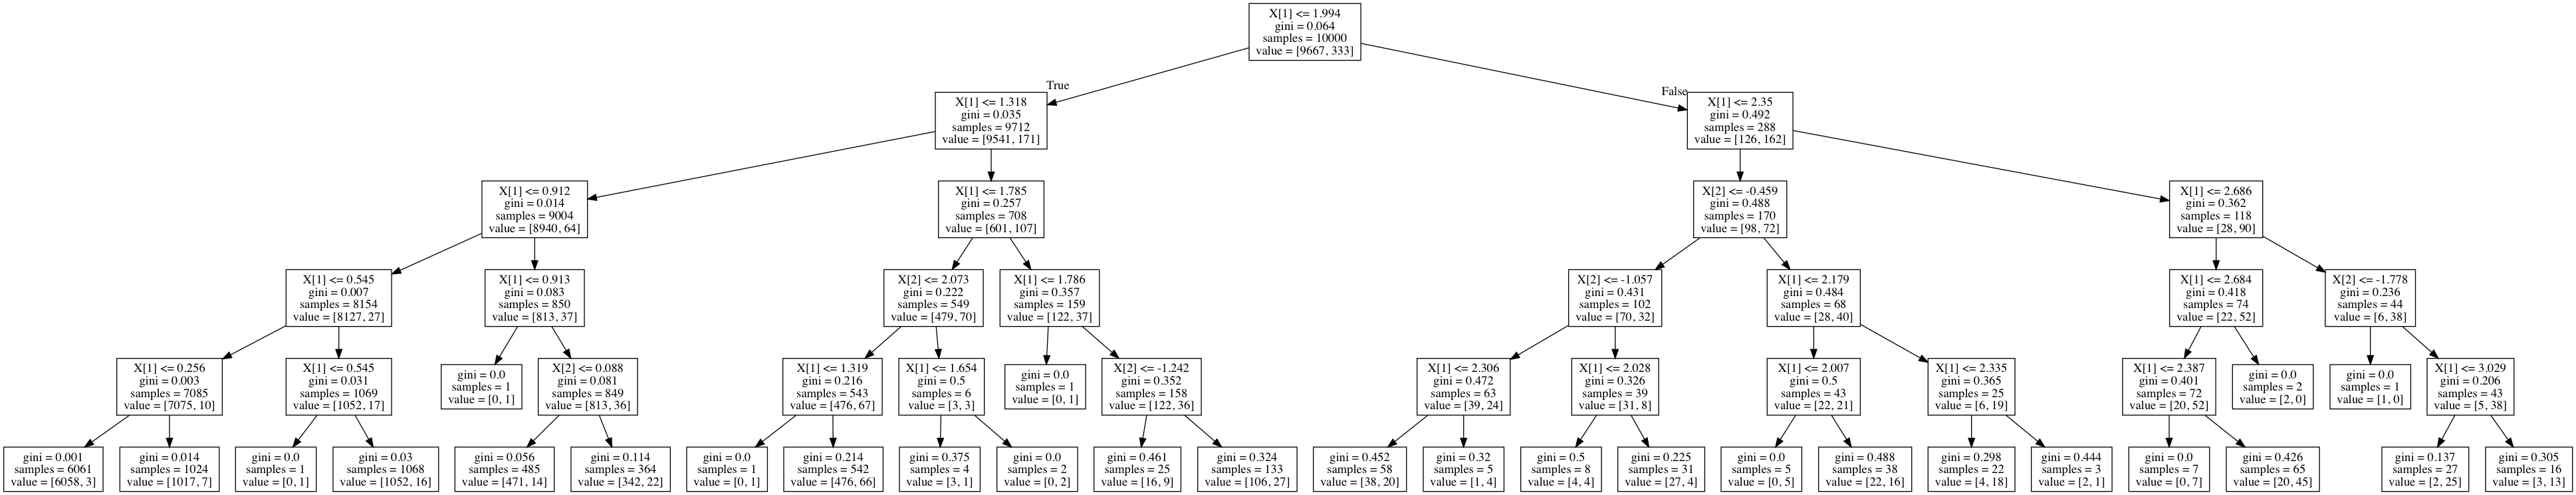

In [8]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy.random as nprnd
import random
import seaborn
%matplotlib inline
from __future__ import print_function
import pydotplus
import os
import subprocess
from sklearn.datasets import load_iris
from sklearn import tree
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from IPython.display import Image  

scaler = StandardScaler()
X = scaler.fit_transform(X)

clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X,y)
y_pred = clf.predict(X_test)

def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.
    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

dot_data=export_graphviz(clf, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

8) Find the optimal decision tree depth and compute the AUC ROC. 

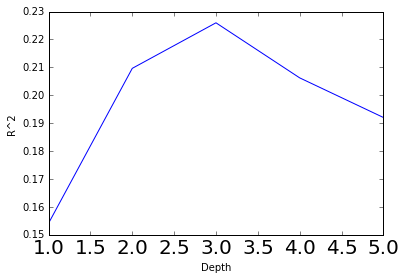

Area under the ROC curve : 0.962152


In [9]:
# Fit regression model
from sklearn.model_selection import train_test_split
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,6)
for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)

test_errors=scores
n_opt=depths[np.argmax(scores)]
plt.show()

i = np.arange(len(tpr)) # index for df
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')

The Optimal depth is 3.

# Part II: Recommendation Systems. 

In this problem we will use the notebook https://github.com/Columbia-Intro-Data-Science/APMAE4990-/blob/master/notebooks/matrix_factorization_recommender.ipynb  as
a starting point.

1) Split the ratings matrix `R_df` into training and testing sets. Remember we need to do this for rows and columns now. 

2) Evaluate the performance of the matrix factorization model for $K=50$. In particular, measure the:
 - Precision.
 - Recall. 

You can round up or down to the nearest integer for the ratings. 

3) Construct an item/item and user/user model, and evaluate the performance as in 2). How does it compare?

4) Check how your answer to 3) changes (if at all) as you try different values of K for K=10, 20, 100. 